In [1]:
# CONTAINS ALL NECESSARY FUNCTIONALITY FOR THIS EXERCISE:
from Modules import OIP20_lib_ImageProcessing_V7_16bit as ip  
# (for this to work, you need:
#  * a subfolder named "Modules" in your Notebook folder
#  * in this subdfolder you need an empty file named "__init__.py"
#  * and of course the library (.py file) named "OIP20_lib_ImageProcessing_V1.py")

# if you want to use other functionality here, you need to load the libraries again: 
import matplotlib.pyplot as plt # We need this here only for closing the open windows
import numpy as np # we want to use some math...
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.io import imread_collection
from Modules import tictoc as t



# for nice(r) potting in the notebook
%matplotlib inline 

##  If not in Jupyter: close all open plots (otherwise you will get tons of them after some time...)
# plt.close("all")

# Some house holding: 
#  Higher resolution for figures:
%config InlineBackend.figure_format = 'retina' # (doubles the plot dpi)

# for interactive graphing: 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ad84c25340>)

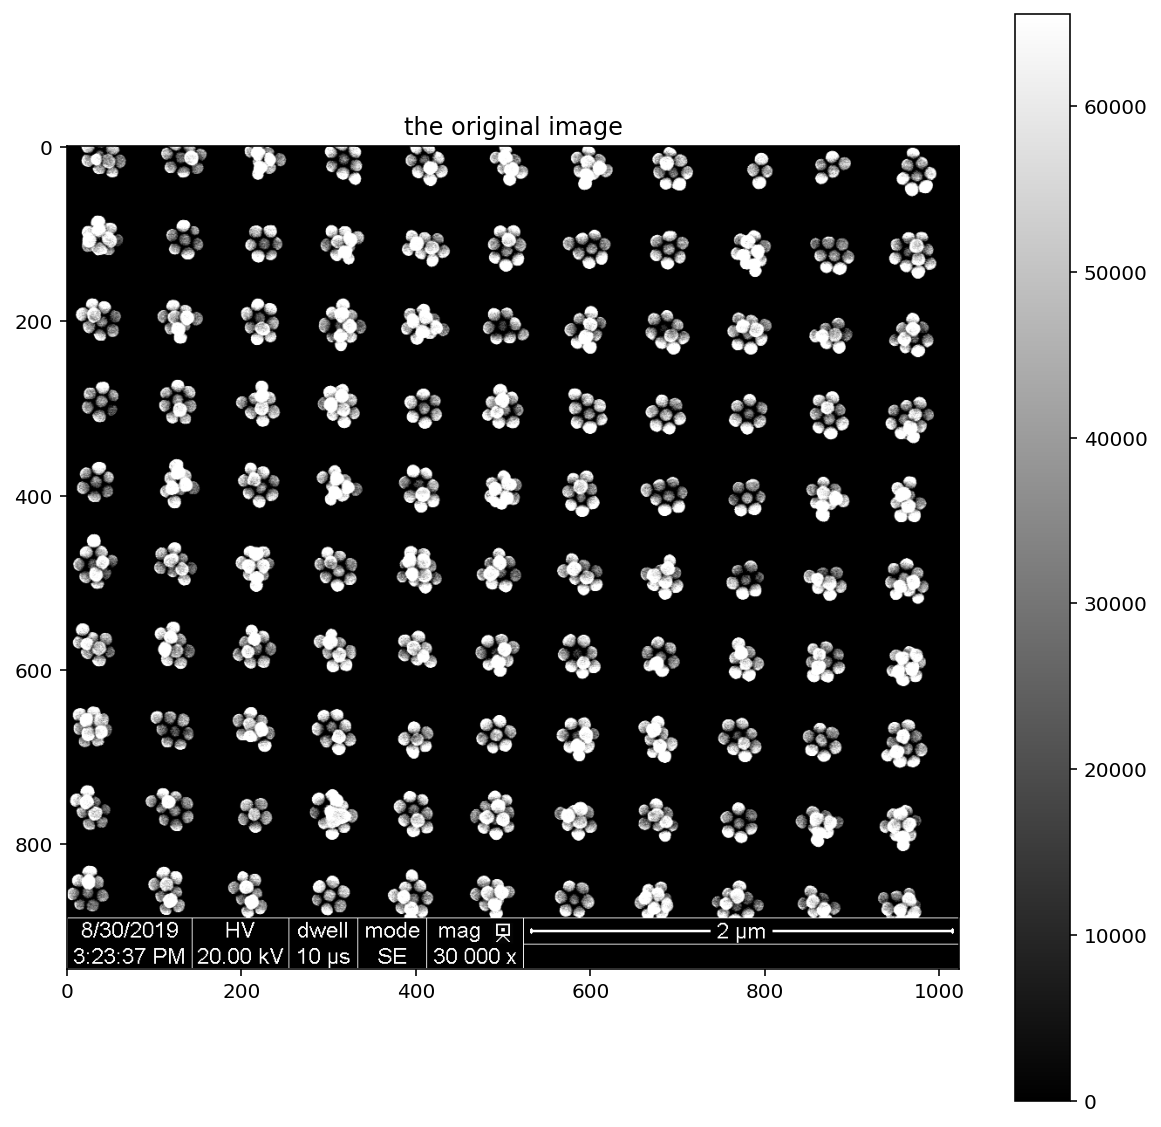

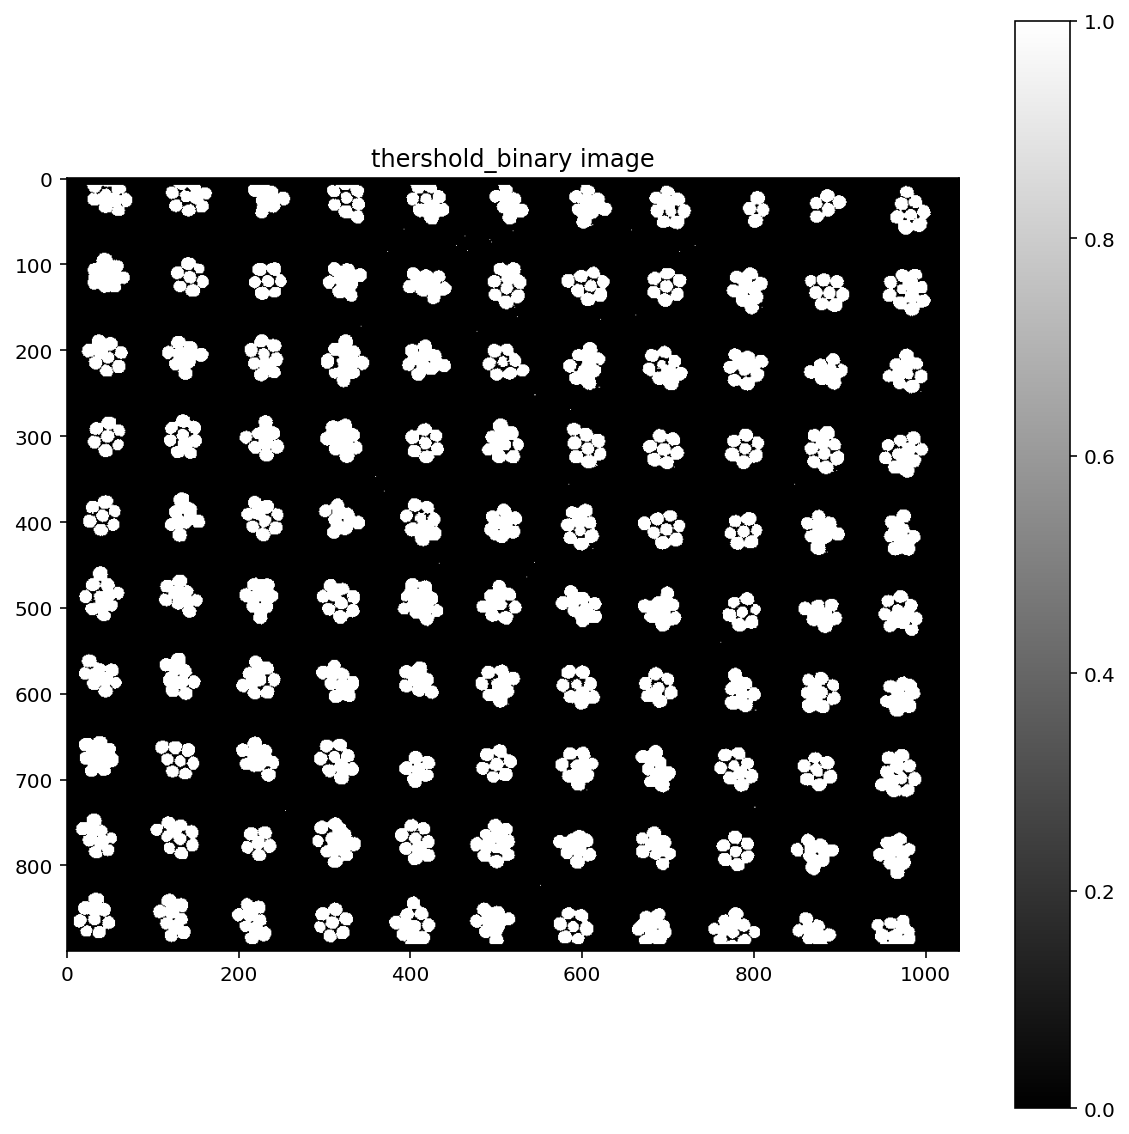

In [2]:
#load the original image from the dataset
pics = ['./images/dataset/001_001.tif',           #0           
        './images/dataset/001_006.tif']            #1
picNUM = 0

# load the image
img = mpimg.imread(pics[picNUM])
# plot the image
ip.plot_image(img, title="the original image")

# crop the footer of the image
img = img[0:884,:] # the same for both images
# plot the image
# ip.plot_image(img, title="the cropped image")

img = np.pad(img, ((8, 8), (8, 8)), 'minimum').astype(np.float)
# plot the image
# ip.plot_image(img, title="the padded image")

# convert the image to binary image
imgBIN = ip.threshold_binary(img, 1)
ip.plot_image(imgBIN, title="thershold_binary image", vmin=0, vmax=1)

In [3]:
t.tic()
# reduce noise and connect near particles each cluster
# imgBIN = ip.img_open(imgBIN, ip.N4)
# morpho_imgBIN = ip.img_dilate(imgBIN, ip.N4)

# reduce noise
morpho_imgBIN=ndi.binary_erosion(imgBIN)
# connect near particles each cluster
morpho_imgBIN=ndi.binary_dilation(morpho_imgBIN,iterations=4)
# convert boolean array to int array for processing
morpho_imgBIN = morpho_imgBIN.astype(int)
t.toc()

Elapsed time: 0.048030 seconds.



0.04803013801574707

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ad84f05c40>)

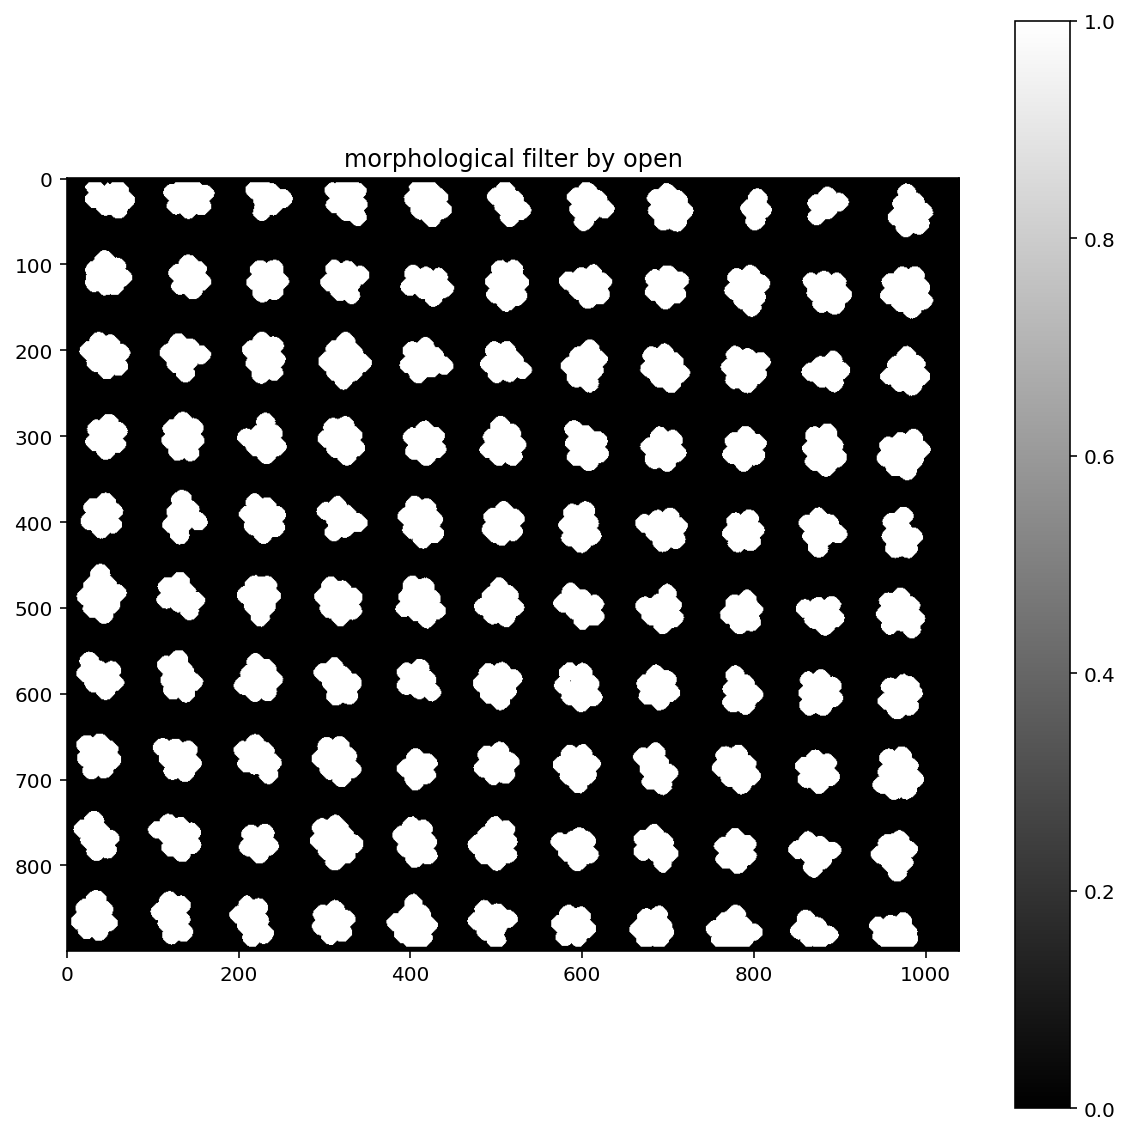

In [4]:
ip.plot_image(morpho_imgBIN,title="morphological filter by open", vmin=0, vmax=1)

(900, 1040)
Relevant foreground pixels: 224309
Elapsed time: 369.606406 seconds.



(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ad849f8ac0>)

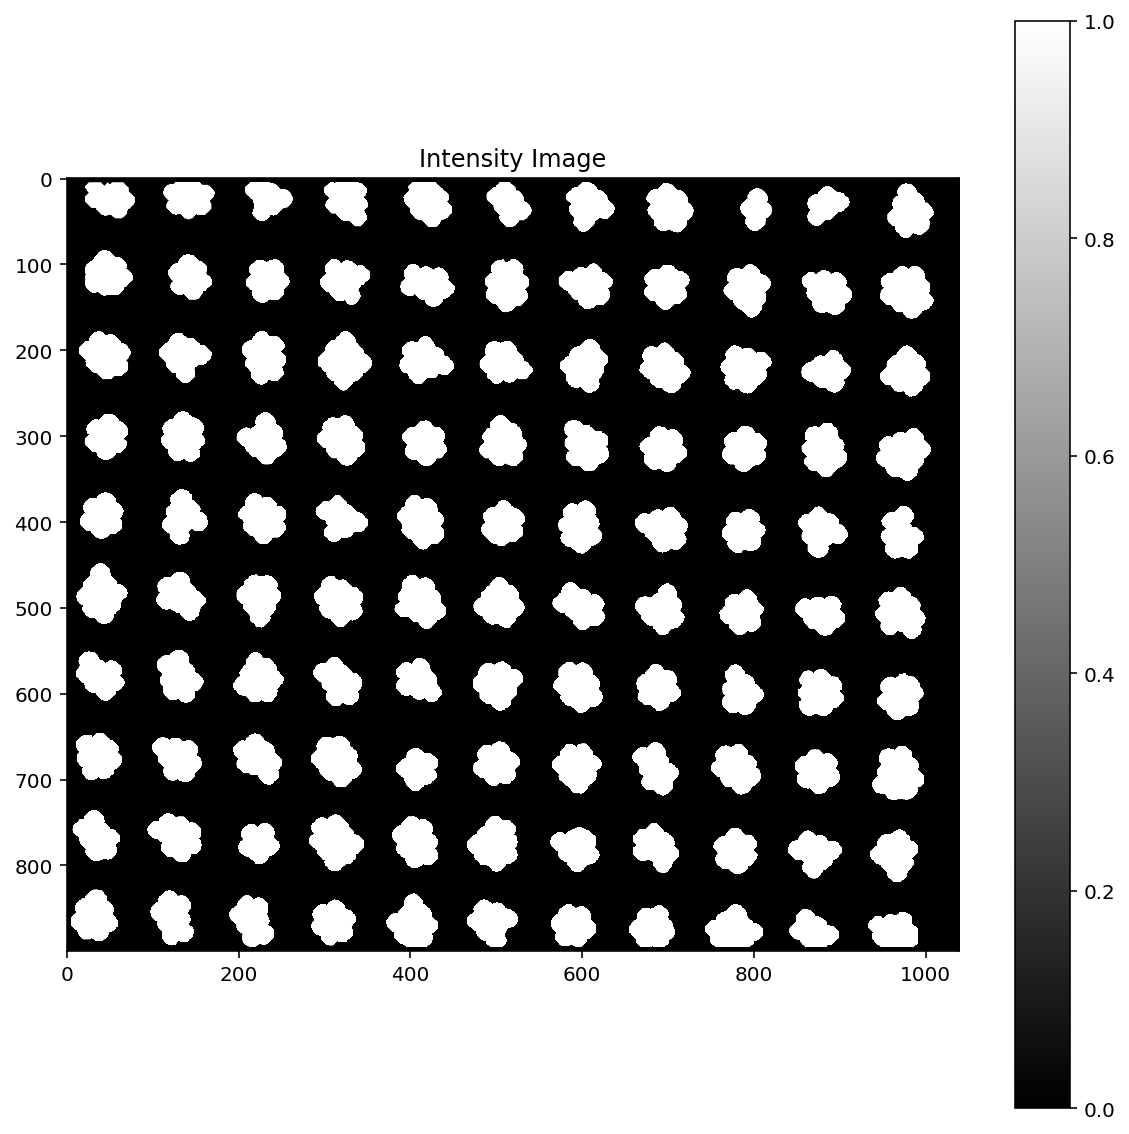

In [5]:
t.tic()
print(morpho_imgBIN.shape)
# SequentialLabeling runs faster than FloodFillLabeling, but when running with the first image, it gets an error(no data for label 6) 
# imgLABEL = ip.SequentialLabeling(morpho_imgBIN)
imgLABEL = ip.FloodFillLabeling(morpho_imgBIN, method='BF') # I have changed the code a litte bit to label the objects in order
t.toc()
ip.plot_image(imgLABEL, cmap = plt.cm.gray, vmax=1)

In [6]:
cluster_position = []
number_of_cluster = np.amax(imgLABEL) #the maximum value of the image is equal the number of labeled regions
print(number_of_cluster)
# get the coordinate of each cluster
for i in range(1,number_of_cluster+1):
    xmin = min(np.where(imgLABEL == i)[1]) # left
    xmax = max(np.where(imgLABEL == i)[1]) # right
    ymin = min(np.where(imgLABEL == i)[0]) # top
    ymax = max(np.where(imgLABEL == i)[0]) # bottom
    cluster_position.append((ymin, ymax, xmin, xmax))

110


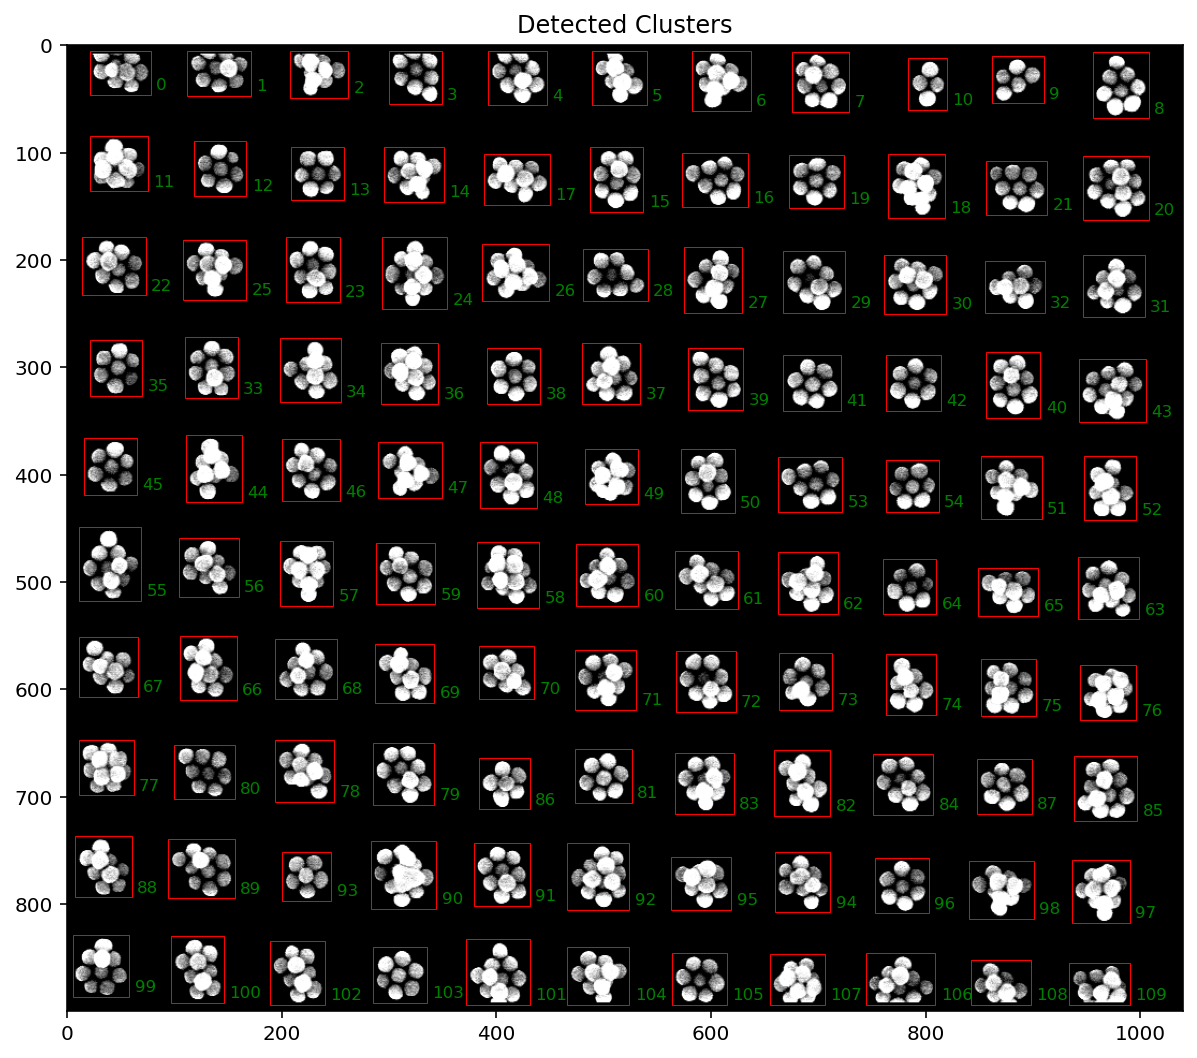

In [7]:
# plot original image with rectangles around all detected clusters
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Detected Clusters")
ax.imshow(img, cmap='gray', vmax=65535)
for i in range(0, number_of_cluster):
    ymin, ymax, xmin, xmax = cluster_position[i]
    rect = plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, linewidth=0.5, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(xmax+5, ymax-5, str(i), fontsize = 'small', color='green')

In [8]:
def load_process_img(img, plot):
    #convert the image of the cluster to binary image
    imgBIN=ip.threshold_binary(img,1) 
    
    # Distance transform
    IMG_DIST = ip.DistanceTransform(imgBIN)

    # Find the local maxima in the distance map:
    local_maxi = peak_local_max(IMG_DIST, indices=False, footprint=np.ones((5, 5)), min_distance=1, labels=imgBIN)

    # Define these Maxima as "seed points" / labels for the marker-based watershed: 
    markers = ndi.label(local_maxi)[0]

    # Run the watershed (on the inversed distance map:)
    labels = watershed(-IMG_DIST, markers, mask=imgBIN)
   
    # Plot the results: 
    if plot:
        fig, axes = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True)
        ax = axes.ravel()
        
        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title('Original objects')
        ax[1].imshow(imgBIN, cmap=plt.cm.gray)
        ax[1].set_title('Binary objects')
        ax[2].imshow(IMG_DIST, cmap=plt.cm.gray)
        ax[2].set_title('Distances')
        ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
        ax[3].set_title('Separated objects')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    
    return labels

In [9]:
particles_each_cluster = []
for i in range(0,number_of_cluster):
    ymin, ymax, xmin, xmax = cluster_position[i]
    cluster = img[ymin:ymax, xmin:xmax]
    imgLabels = load_process_img(cluster,plot=False)
    cnt = np.amax(imgLabels)
    particles_each_cluster.append(cnt)

import collections

collect_particles = collections.Counter(particles_each_cluster)
print(collect_particles) 

Counter({8: 22, 7: 22, 10: 17, 9: 12, 5: 8, 11: 8, 13: 6, 6: 4, 12: 3, 4: 2, 3: 2, 2: 1, 17: 1, 15: 1, 16: 1})


In [23]:
# def convert2array(result):  
#     reArray = np.zeros(round(max(result.keys())).astype(int)+1)
#     for (keys,values) in result.items():
#         keys = round(keys).astype(int)
#         reArray[keys] = values
#     return reArray

# this can run with Ucloud
def convert2array(result):  
    reArray = np.zeros(int(round(max(result.keys())))+1)
    for (keys,values) in result.items():
        keys = int(round(keys))
        reArray[keys] = values
    return reArray

In [24]:
from matplotlib.ticker import MaxNLocator

def plot_result(result, xlabel='x', ylabel='y'):
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel, color='tab:blue')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    markerline, stemline, baseline = ax[0].stem(result, markerfmt=' ',basefmt=' ', use_line_collection=True)

    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel, color='tab:blue')
    ax[1].boxplot(result)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel(ylabel, color='tab:blue')
    ax[2].violinplot(result)
    plt.setp(stemline, linewidth = 10)
    plt.setp(markerline, markersize = 5)
    plt.show() 

In [25]:
def statistic(result):
#     print(result)
    print(np.mean(result)) # sum of all the entries divided by the number of entries / the average value 
    print(np.median(result)) # the middle point of the number of entries
    print(np.var(result)) # measures how far a set of numbers is spread out from their average value
    print(np.std(result)) # a measure of the amount of variation or dispersion of a set of values.

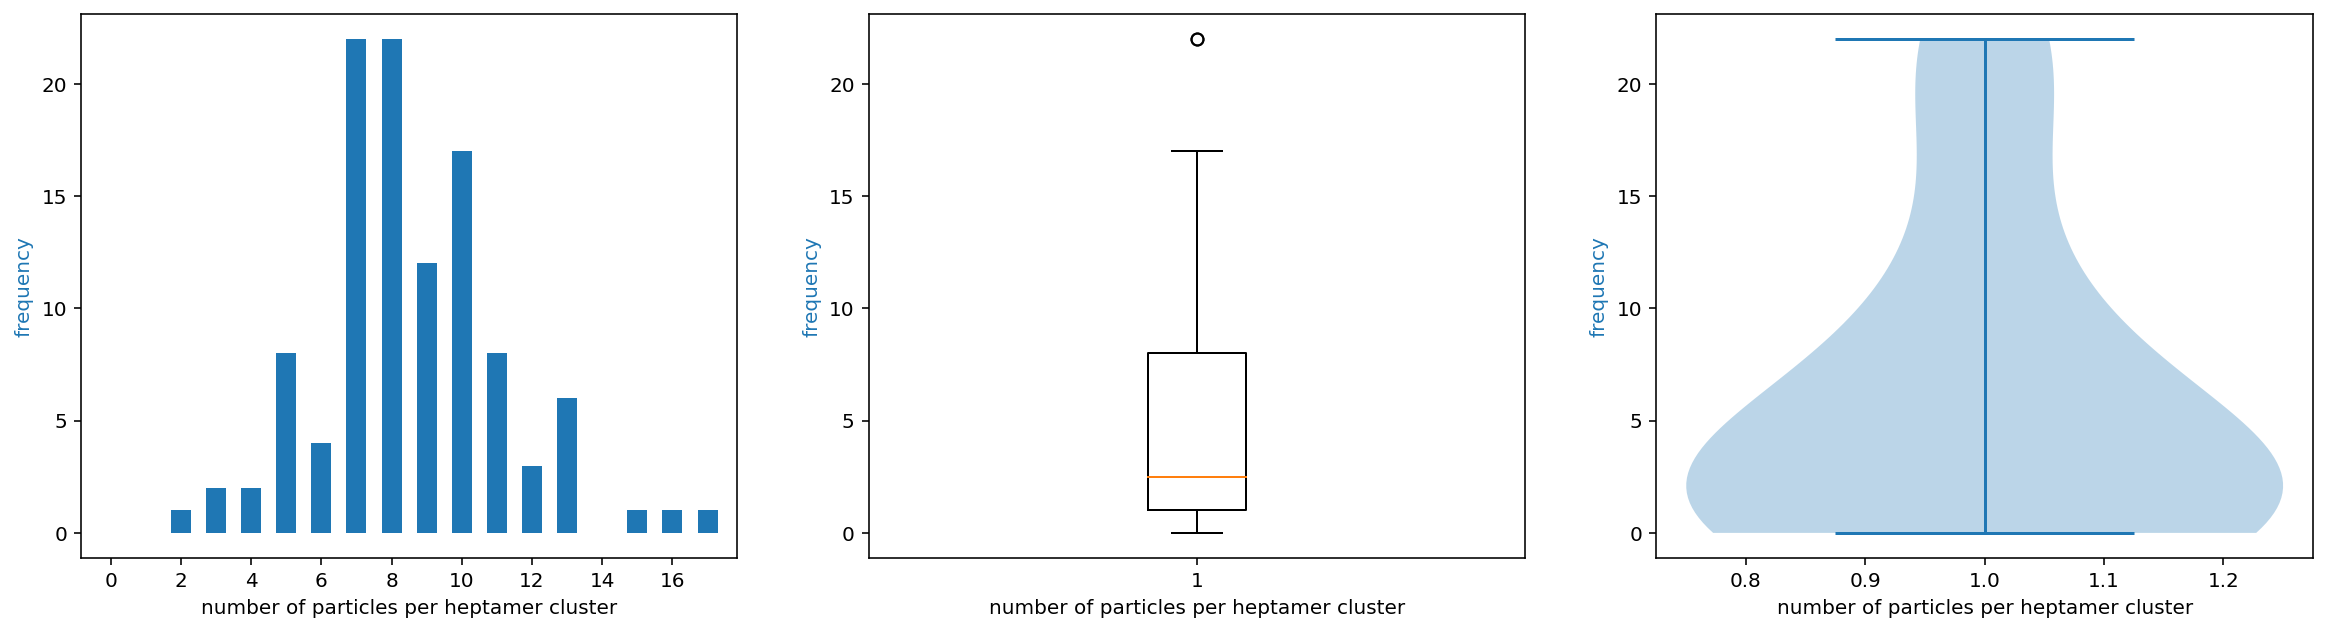

In [26]:
plot_result(convert2array(collect_particles), xlabel='number of particles per heptamer cluster', ylabel='frequency')

In [14]:
statistic(particles_each_cluster)

8.527272727272727
8.0
6.740165289256198
2.5961828304755805


In [15]:
def measure_diameter(labels):
    diameter = []
    for i in range(1, np.amax(labels)+1):
        xd = np.max(np.sum(labels==i, axis=1)) # get the longest diameter with respect to X axis
        yd = np.max(np.sum(labels==i, axis=0)) # get the longest diameter with respect to Y axis
        d = max(xd,yd)
        diameter.append(d) # compare both axis and get the longer diameter
    return diameter

def get_chain_ratio(img, img_number):
    # crop the image to get the ruler
    if img_number == 0:
        img_ruler=img[890:915, 525:1020] # 001_001.tif
        mag = 30000
    elif img_number == 1:
        img_ruler=img[890:915, 700:1020] #001_006.tif
        mag = 15000
    img_ruler = ip.threshold_binary(img_ruler,np.mean(img_ruler))
    left_point = min(np.where(img_ruler == 1)[1]) # return the left edge of the ruler
    right_point = max(np.where(img_ruler == 1)[1]) # return the right edge of the ruler
    number_pixel_of_ruler = right_point - left_point
    return number_pixel_of_ruler

def pixel_to_meter(measure_in_pixel, ratio):
    measure_in_meter = []
    for i in measure_in_pixel:
        measure_in_meter.append((1000* i * 2 / ratio)) # 2 micro meters
    return measure_in_meter

In [16]:
diameter_each_particle = []
ruler = get_chain_ratio(img,picNUM)
for i in range(0,number_of_cluster):
    ymin, ymax, xmin, xmax = cluster_position[i]
    cluster = img[ymin:ymax, xmin:xmax]
    imgLabels = load_process_img(cluster,plot=False)
    diameter_in_pixel = measure_diameter(imgLabels)
    diameter_in_meter = pixel_to_meter(diameter_in_pixel, ruler)
    diameter_each_particle = diameter_each_particle + diameter_in_meter

import collections

collect_diameter = collections.Counter(diameter_each_particle)
print(collect_diameter)

Counter({78.239608801956: 239, 73.34963325183374: 179, 83.12958435207824: 133, 68.45965770171149: 91, 88.01955990220048: 49, 63.56968215158924: 47, 58.67970660146699: 29, 53.789731051344745: 12, 151.58924205378972: 11, 44.00977995110024: 10, 39.119804400978: 10, 141.80929095354523: 9, 4.88997555012225: 9, 34.229828850855746: 9, 117.35941320293398: 9, 156.479217603912: 8, 122.24938875305624: 8, 146.69926650366747: 8, 107.57946210268949: 7, 48.899755501222494: 7, 102.68948655256723: 6, 132.02933985330074: 5, 19.559902200489: 4, 112.46943765281173: 4, 127.13936430317848: 4, 9.7799511002445: 4, 97.79951100244499: 4, 92.90953545232274: 4, 166.25916870415648: 3, 24.449877750611247: 2, 224.93887530562347: 2, 136.91931540342298: 2, 161.36919315403424: 2, 229.8288508557457: 1, 215.15892420537898: 1, 29.339853300733495: 1, 14.669926650366747: 1, 171.14914425427872: 1, 180.92909535452324: 1, 185.81907090464549: 1, 195.59902200488997: 1})


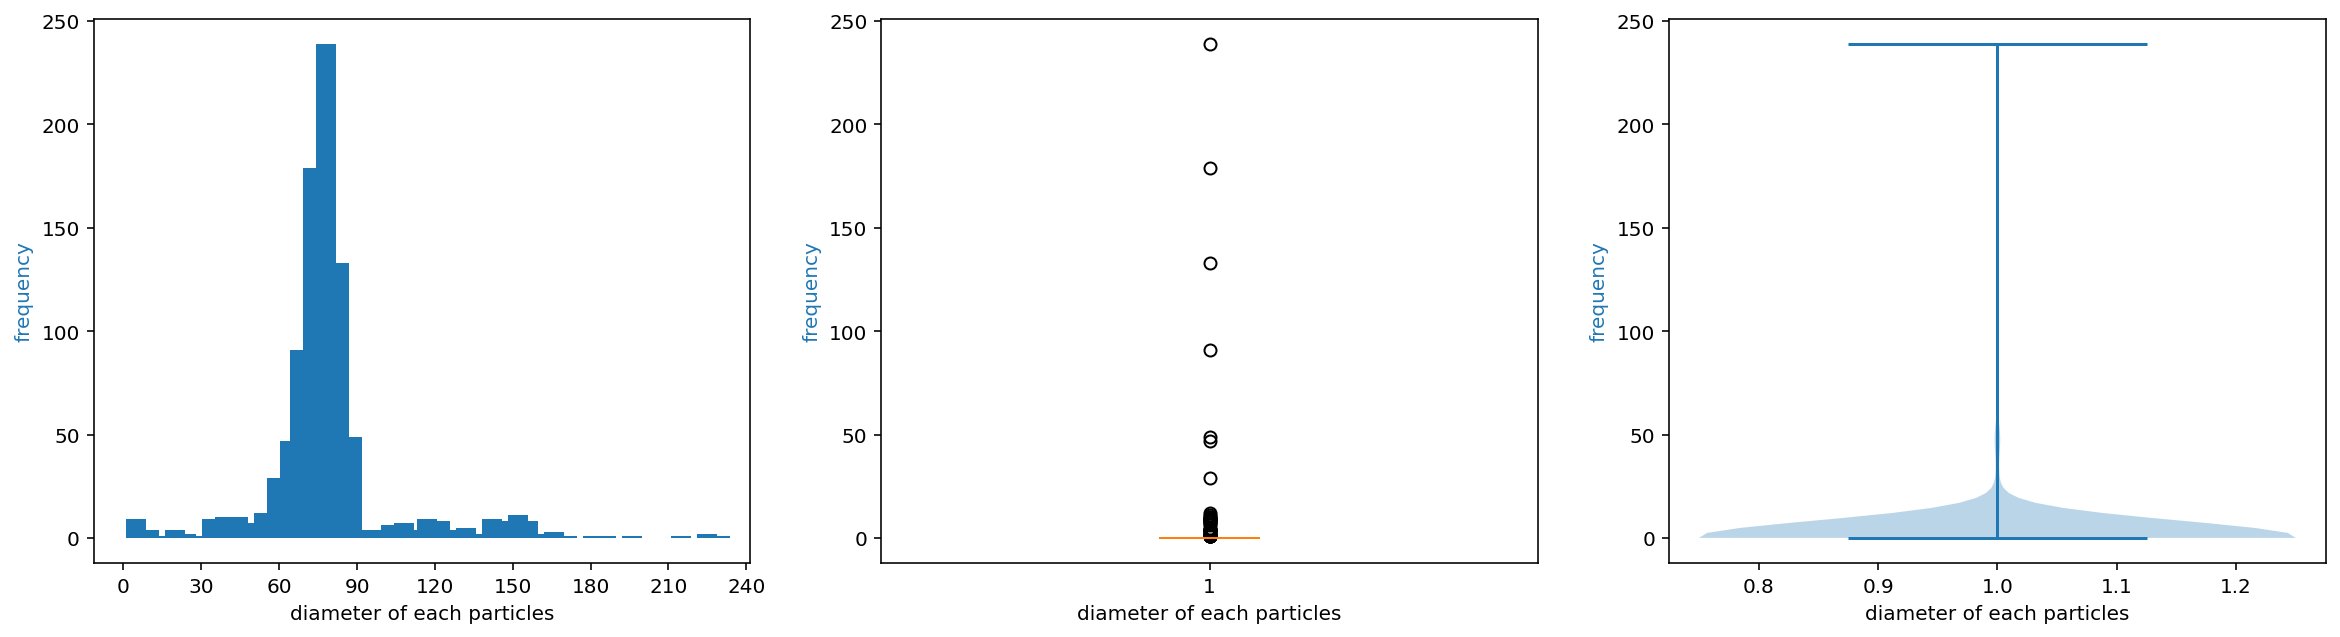

In [17]:
plot_result(convert2array(collect_diameter), xlabel='diameter of each particles', ylabel='frequency')

In [18]:
statistic(diameter_each_particle)

79.29267389910386
78.239608801956
657.8693095179166
25.648963127540195
